In [19]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
import numpy as np
from fastai.vision import *
from fastai.metrics import error_rate
import random

In [21]:
bs = 64

In [22]:
path = '/home/temp/Documents/images_corrected_no_classes/'

img_folder = 'images/'    # Let img_folder be a directory of a small image dataset for quick debugging

In [23]:
measles_img = get_image_files(path + img_folder + "Measles")
not_measles_img = get_image_files(path + img_folder + "Not_Measles")

print(len(measles_img), len(not_measles_img))

158 1158


# Cross validation

As we have a small data set, to obtain robust results, we perform cross validation by partitioning all images into 5 sets.

In [24]:
random.shuffle(measles_img)
random.shuffle(not_measles_img)

cut_point_m = [int(len(measles_img)* n/5) for n in range(1,5)]
cut_point_n = [int(len(not_measles_img)* n/5) for n in range(1,5)]

print(cut_point_m)
print(cut_point_n)

[31, 63, 94, 126]
[231, 463, 694, 926]


The following shows how to define the five validation sets and the corresponding training sets, each of which is the complement of the related validation set:

    valid1 = not_measles_img[0:cut_point_n[0]] + measles_img[0:cut_point_m[0]]
    train1 = set(not_measles_img + measles_img) - set(valid1)

    valid2 = not_measles_img[cut_point_n[0]:cut_point_n[1]] + measles_img[cut_point_m[0]:cut_point_m[1]]
    train2 = set(not_measles_img + measles_img) - set(valid2)

    valid3 = not_measles_img[cut_point_n[1]:cut_point_n[2]] + measles_img[cut_point_m[1]:cut_point_m[2]]
    train3 = set(not_measles_img + measles_img) - set(valid3)

    valid4 = not_measles_img[cut_point_n[2]:cut_point_n[3]] + measles_img[cut_point_m[2]:cut_point_m[3]]
    train4 = set(not_measles_img + measles_img) - set(valid4)

    valid5 = not_measles_img[cut_point_n[3]:len(not_measles_img)] + measles_img[cut_point_m[3]:len(measles_img)]
    train5 = set(not_measles_img + measles_img) - set(valid5)

Prepare directories required to store symlinks of image files

In [25]:
%cd $path
!mkdir -p valid/Measles valid/Not_Measles train/Measles train/Not_Measles


/home/temp/Documents/images_corrected_no_classes


In [26]:
def create_img_symlinks(fnames, folder, rm_file=True):
  %cd $folder 
  if rm_file:
    %rm -f *
  for f in fnames:
    !ln -s "$f" .

In [27]:
def prepare_img_files(idx_min_m, idx_max_m, idx_min_n, idx_max_n):
    # Create symlinks for images in validation set
    create_img_symlinks(    measles_img[idx_min_m:idx_max_m], path+"valid/Measles")
    create_img_symlinks(not_measles_img[idx_min_n:idx_max_n], path+"valid/Not_Measles")    
    # Create symlinks for images in training set
    if idx_min_m>0:
        create_img_symlinks(measles_img[:idx_min_m],      path+"train/Measles")
    if idx_max_m<len(measles_img):
        create_img_symlinks(measles_img[idx_max_m:],      path+"train/Measles", idx_min_m==0)
    if idx_min_n>0:
        create_img_symlinks(not_measles_img[:idx_min_n],  path+"train/Not_Measles")
    if idx_max_n<len(not_measles_img):
        create_img_symlinks(not_measles_img[idx_max_n:],  path+"train/Not_Measles", idx_min_n==0)

In [28]:
def model_training(mdl_idx):
    data = ImageDataBunch.from_folder(path= path, train='train', valid='valid', bs=bs, ds_tfms=get_transforms(), 
                                  size=299, num_workers=0).normalize(imagenet_stats)
    learn = cnn_learner(data, models.resnet50, metrics={error_rate,accuracy,AUROC})
    #
    learn.fit_one_cycle(8)
    #
    mdl_name = 'stage-3-50-'+str(mdl_idx)
    learn.save(mdl_name)
    #
    interp = ClassificationInterpretation.from_learner(learn)
    #
    interp.most_confused(min_val=2)
    #
    interp.plot_confusion_matrix(figsize=(6,6),dpi=60)
    #
    learn.unfreeze()
    #
    learn.lr_find()
    learn.recorder.plot()
    #
    learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))
    #
    # learn.load(mdl_name);
    #
    interp = ClassificationInterpretation.from_learner(learn)
    #
    interp.most_confused(min_val=2)
    #
    interp.plot_confusion_matrix(figsize=(6,6),dpi=60)
    #
    #create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used)
    learn.export()
    #saved in the training images file
    #
    from_file = path + "/export.pkl"
    to_file = path + "/models/export-" + str(mdl_idx) + ".pkl"
    %mv $from_file $to_file

## First iteration of cross validation

/home/temp/Documents/images_corrected_no_classes/valid/Measles
/home/temp/Documents/images_corrected_no_classes/valid/Not_Measles
/home/temp/Documents/images_corrected_no_classes/train/Measles
/home/temp/Documents/images_corrected_no_classes/train/Not_Measles


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.153392,0.836448,0.580153,0.419847,07:33
1,1.066412,0.577776,0.782443,0.217557,07:31
2,0.822183,0.336804,0.858779,0.141221,07:31
3,0.630455,0.210280,0.916031,0.083969,07:31
4,0.491938,0.159990,0.942748,0.057252,07:32
5,0.389261,0.170585,0.938931,0.061069,07:31
6,0.310318,0.155273,0.942748,0.057252,07:32
7,0.258472,0.137824,0.950382,0.049618,07:40


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.163442,0.136667,0.958015,0.041985,09:04
1,0.135606,0.128543,0.950382,0.049618,09:08
2,0.126562,0.128060,0.950382,0.049618,09:20


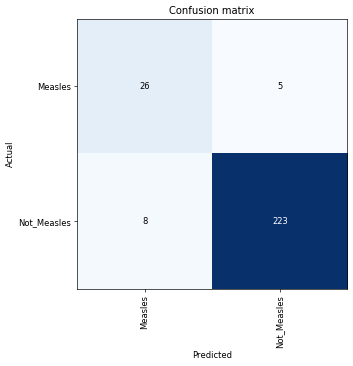

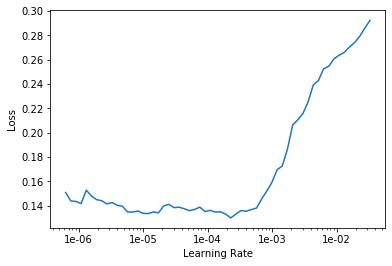

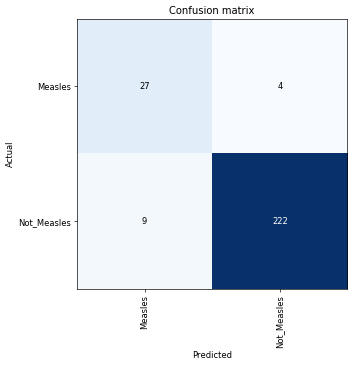

In [29]:
# Validation set: measles_img[0:cut_point_m[0]] + not_measles_img[0:cut_point_n[0]]
# Training set: not_measles_img + measles_img - Validation set
    
prepare_img_files(0, cut_point_m[0], 0, cut_point_n[0])

np.random.seed(42)
model_training(1)

## Second iteration of cross validation

/home/temp/Documents/images_corrected_no_classes/valid/Measles
/home/temp/Documents/images_corrected_no_classes/valid/Not_Measles
/home/temp/Documents/images_corrected_no_classes/train/Measles
/home/temp/Documents/images_corrected_no_classes/train/Measles
/home/temp/Documents/images_corrected_no_classes/train/Not_Measles
/home/temp/Documents/images_corrected_no_classes/train/Not_Measles


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.142989,0.752734,0.662879,0.337121,07:32
1,0.976955,0.630469,0.753788,0.246212,07:32
2,0.763586,0.385744,0.878788,0.121212,07:33
3,0.606462,0.186420,0.939394,0.060606,07:33
4,0.475352,0.181834,0.928030,0.071970,07:32
5,0.383185,0.157135,0.946970,0.053030,07:32
6,0.308852,0.133745,0.946970,0.053030,07:33
7,0.262660,0.130341,0.946970,0.053030,07:33


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.145735,0.132654,0.950758,0.049242,09:06
1,0.123124,0.136543,0.954545,0.045455,09:05
2,0.125983,0.133046,0.950758,0.049242,09:05


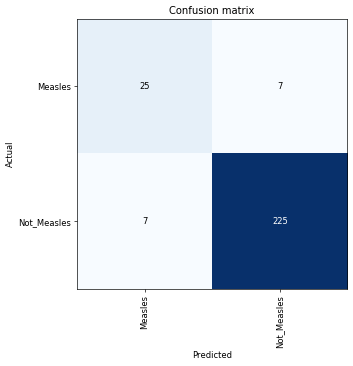

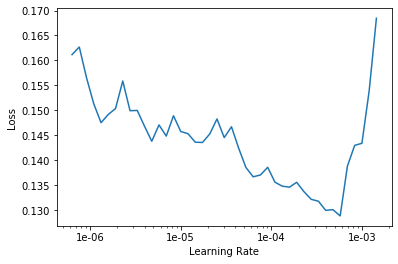

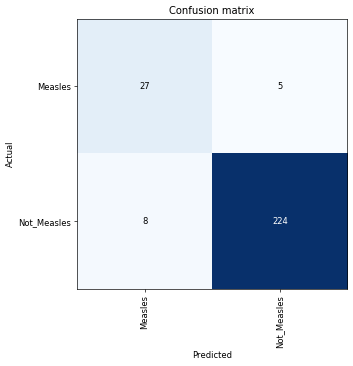

In [30]:
# Validation set: not_measles_img[cut_point_n[0]:cut_point_n[1]] + measles_img[cut_point_m[0]:cut_point_m[1]]
# Traing set: not_measles_img + measles_img - Validation set
   
prepare_img_files(cut_point_m[0], cut_point_m[1], cut_point_n[0], cut_point_n[1])

model_training(2)

## Third iteration of cross validation

/home/temp/Documents/images_corrected_no_classes/valid/Measles
/home/temp/Documents/images_corrected_no_classes/valid/Not_Measles
/home/temp/Documents/images_corrected_no_classes/train/Measles
/home/temp/Documents/images_corrected_no_classes/train/Measles
/home/temp/Documents/images_corrected_no_classes/train/Not_Measles
/home/temp/Documents/images_corrected_no_classes/train/Not_Measles


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.261727,0.683654,0.717557,0.282443,07:33
1,1.111549,0.707645,0.782443,0.217557,07:38
2,0.862197,0.301845,0.854962,0.145038,07:33
3,0.653772,0.190069,0.931298,0.068702,07:33
4,0.507161,0.157466,0.950382,0.049618,07:32
5,0.399961,0.137364,0.954198,0.045802,07:33
6,0.325156,0.138638,0.950382,0.049618,07:33
7,0.269369,0.139029,0.950382,0.049618,07:33


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.167797,0.137506,0.958015,0.041985,09:09
1,0.150889,0.126516,0.958015,0.041985,09:06
2,0.139489,0.127173,0.961832,0.038168,09:09


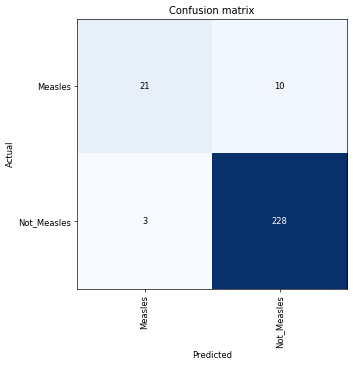

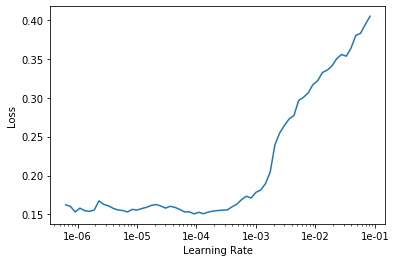

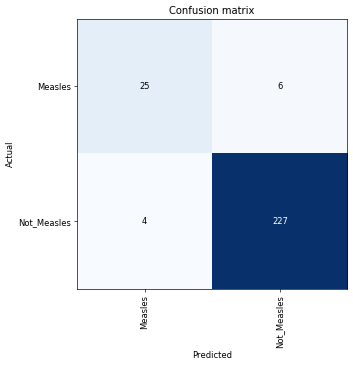

In [31]:
# Validation set: not_measles_img[cut_point_n[1]:cut_point_n[2]] + measles_img[cut_point_m[1]:cut_point_m[2]]
# Traing set: not_measles_img + measles_img - Validation set
    
prepare_img_files(cut_point_m[1], cut_point_m[2], cut_point_n[1], cut_point_n[2])

model_training(3)

## Fourth iteration of cross validation

/home/temp/Documents/images_corrected_no_classes/valid/Measles
/home/temp/Documents/images_corrected_no_classes/valid/Not_Measles
/home/temp/Documents/images_corrected_no_classes/train/Measles
/home/temp/Documents/images_corrected_no_classes/train/Measles
/home/temp/Documents/images_corrected_no_classes/train/Not_Measles
/home/temp/Documents/images_corrected_no_classes/train/Not_Measles


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.170413,1.118624,0.583333,0.416667,07:36
1,1.008783,0.666770,0.712121,0.287879,07:34
2,0.797590,0.509419,0.814394,0.185606,07:34
3,0.615230,0.377260,0.867424,0.132576,07:46
4,0.491609,0.304035,0.893939,0.106061,07:35
5,0.384632,0.219519,0.916667,0.083333,07:34
6,0.313101,0.199272,0.939394,0.060606,07:34
7,0.264244,0.194553,0.943182,0.056818,07:34


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.121237,0.188654,0.943182,0.056818,09:12
1,0.125963,0.184566,0.939394,0.060606,09:09
2,0.128972,0.182261,0.931818,0.068182,09:06


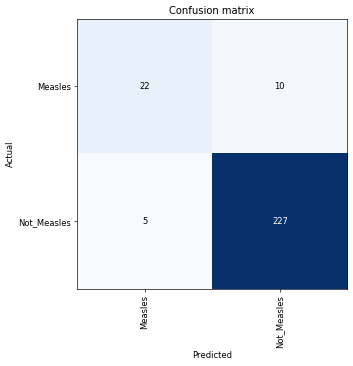

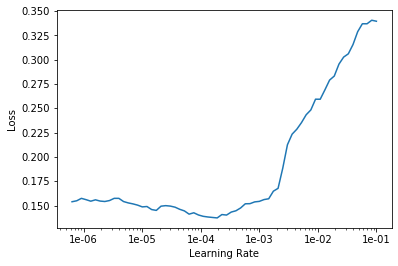

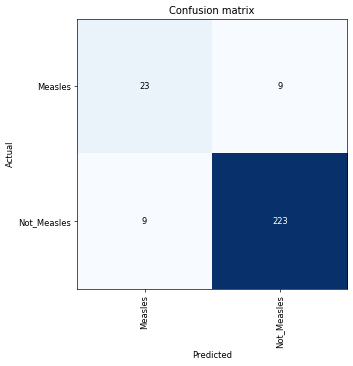

In [32]:
# Validation set: not_measles_img[cut_point_n[2]:cut_point_n[3]] + measles_img[cut_point_m[2]:cut_point_m[3]]
# Traing set: not_measles_img + measles_img - Validation set

prepare_img_files(cut_point_m[2], cut_point_m[3], cut_point_n[2], cut_point_n[3])

model_training(4)

## Fifth iteration of cross validation

/home/temp/Documents/images_corrected_no_classes/valid/Measles
/home/temp/Documents/images_corrected_no_classes/valid/Not_Measles
/home/temp/Documents/images_corrected_no_classes/train/Measles
/home/temp/Documents/images_corrected_no_classes/train/Not_Measles


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.193444,0.955686,0.602273,0.397727,07:37
1,1.020360,0.959412,0.678030,0.321970,07:35
2,0.805507,0.252224,0.912879,0.087121,07:35
3,0.633879,0.232602,0.912879,0.087121,07:34
4,0.494187,0.224507,0.920455,0.079545,07:36
5,0.397417,0.161579,0.946970,0.053030,07:35
6,0.317304,0.143670,0.946970,0.053030,07:36
7,0.266629,0.142249,0.946970,0.053030,07:34


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.146795,0.133536,0.946970,0.053030,09:07
1,0.136050,0.122046,0.969697,0.030303,09:10
2,0.133020,0.123912,0.965909,0.034091,09:09


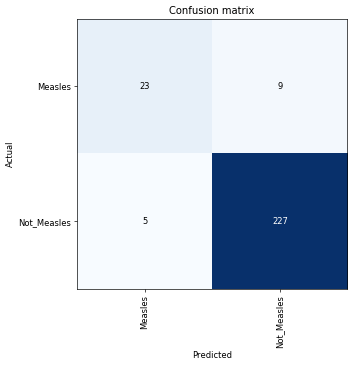

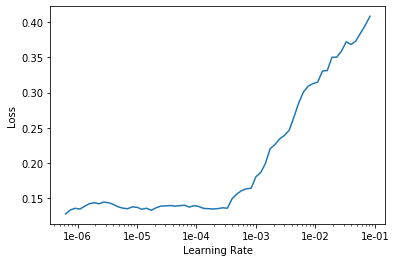

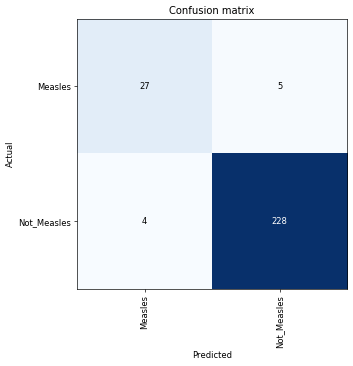

In [33]:
# Validation set: not_measles_img[cut_point_n[3]:len(not_measles_img)] + measles_img[cut_point_m[3]:len(measles_img)]
# Traing set: not_measles_img + measles_img - Validation set

prepare_img_files(cut_point_m[3], len(measles_img), cut_point_n[3], len(not_measles_img))

model_training(5)

## Additionaly model analysis

With the models saved, then we can do analysis of our interest

In [1]:
defaults.device = torch.device('cpu')

#use a test image from test file
img = open_image(path + '/samples/Measles/measles(49).jpg')
img

mdl_idx = 1

from_file = path + "/models/export-" + str(mdl_idx) + ".pkl"
to_file = path + "/models/export.pkl"
!ln -s $from_file $to_file

learn = load_learner(path + "models/")
#pkl file

pred_class,pred_idx,outputs = learn.predict(img)
#pred_class

#interp.plot_confusion_matrix(figsize=(6,6),dpi=60)


NameError: name 'torch' is not defined